In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from catboost import CatBoostClassifier

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Считываем даатасет

In [2]:
train_df = pd.read_csv('/kaggle/input/vk-task-dataset/train_spam.csv')
test_df = pd.read_csv('/kaggle/input/vk-task-dataset/test_spam.csv')

In [3]:
train_df

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


Преобразуем ham и spam в 0 и 1 для бинарной классификации 

In [4]:
train_df['text_type'] = train_df['text_type'].map(lambda x: 0 if x=='ham' else 1)

In [5]:
unpreproc_text, target = train_df['text'].tolist(), train_df['text_type'].tolist()

Начнем препроцесс текста

In [6]:
tokenizer = WordPunctTokenizer()
stops = stopwords.words('english') 
stop_marks = ["!", ">", "<", ".", ",", "@", "'", "#", "$", "%", "^", "&", "*", "(", ")", "-", '_', '=', '+', "№", ";", ":", "?", "`", "~", '/', '|', '[', ']', '{', '}']

Для начала уберем все ссылки, смайлики и другие непонятные символы

In [7]:
for_tokens_list = []
for sent in unpreproc_text:
    for_tokens_list.append(re.sub(r'http\S+', '', sent))

for_tokens_list[0]

'make sure alex knows his birthday is over in fifteen minutes as far as youre concerned'

In [8]:
def tokenize_text(sent):
    return [tokenizer.tokenize(sent.lower()) for sent in for_tokens_list]
tokenized_list_of_trash = tokenize_text(for_tokens_list)

In [9]:
def clean_text(sentences, stop_words, stop_marks):
    cleaned_sentences = []
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F700-\U0001F77F" 
        u"\U0001F780-\U0001F7FF"  
        u"\U0001F800-\U0001F8FF" 
        u"\U0001F900-\U0001F9FF"  
        u"\U0001FA00-\U0001FA6F" 
        u"\U0001FA70-\U0001FAFF"  
        u"\U00002702-\U000027B0"  
        u"\U000024C2-\U0001F251"  
        "]",
        flags=re.UNICODE
    )

    for sent in sentences:
        helper = []
        for word in sent:
            word = emoji_pattern.sub('', word)
            cleaned_word = re.sub(r'[^\w\s]', '', word)
            if cleaned_word and cleaned_word not in stop_words and cleaned_word not in stop_marks:
                helper.append(cleaned_word)
        cleaned_sentences.append(helper)
    return cleaned_sentences

clean_sents = clean_text(tokenized_list_of_trash, stops, stop_marks)

In [10]:
clean_sents[:5]

[['make',
  'sure',
  'alex',
  'knows',
  'birthday',
  'fifteen',
  'minutes',
  'far',
  'youre',
  'concerned'],
 ['resume',
  'john',
  'lavorato',
  'thanks',
  'vince',
  'get',
  'moving',
  'right',
  'away',
  'molly',
  'vince',
  'j',
  'kaminski',
  '02',
  '21',
  '2001',
  '05',
  '55',
  'pm',
  'molly',
  'magee',
  'hou',
  'ect',
  'ect',
  'cc',
  'vince',
  'j',
  'kaminski',
  'hou',
  'ect',
  'ect',
  'subject',
  'resume',
  'john',
  'lavorato',
  'molly',
  'please',
  'make',
  'arrangements',
  'interview',
  'candidate',
  'trading',
  'position',
  'interviews',
  'john',
  'lavorato',
  'jeff',
  'shankman',
  'gary',
  'hickerson',
  'stinson',
  'gibner',
  'talked',
  'new',
  'york',
  'considering',
  'opportunities',
  'act',
  'fast',
  'think',
  'john',
  'like',
  'punit',
  'thanks'],
 ['plzz',
  'visit',
  'website',
  'moviesgodml',
  'get',
  'movies',
  'free',
  'also',
  'provide',
  'direct',
  'download',
  'links',
  'redirect',
  'ad

Теперь наш текст готов, чтобы превращать его в векторы. Попробую метод решения задачи: tf-idf + catboost. Можно еще попробовать Word2Vec, но это будет ресурсоемко. BoW не использую потому бесполезно

**1) TF-IDF + CatBoost**

In [11]:
tf_idf = TfidfVectorizer()

In [12]:
sents = []
for new_sent in clean_sents:
    helper = ''
    for word in new_sent:
        helper += ' ' + word
    sents.append(helper.lstrip())
sents

['make sure alex knows birthday fifteen minutes far youre concerned',
 'resume john lavorato thanks vince get moving right away molly vince j kaminski 02 21 2001 05 55 pm molly magee hou ect ect cc vince j kaminski hou ect ect subject resume john lavorato molly please make arrangements interview candidate trading position interviews john lavorato jeff shankman gary hickerson stinson gibner talked new york considering opportunities act fast think john like punit thanks',
 'plzz visit website moviesgodml get movies free also provide direct download links redirect ads',
 'urgent mobile number awarded 2000 prize guaranteed call 09061790121 land line claim 3030 valid 12hrs 150ppm',
 'overview hr associates analyst project per david request attached overview hr associates analysts project creating human resource value index document provide brief top line overview following description challenges people involved positive outcomes high level description process suggest questions tuesday meeti

In [13]:
tf_idf_vectors = tf_idf.fit_transform(sents).toarray()

In [14]:
tf_idf_vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
train_data = pd.DataFrame(tf_idf_vectors)
target = pd.DataFrame(target).rename(columns={0: 'target'})


In [16]:
train_data.shape, target.shape


((16278, 48298), (16278, 1))

In [17]:
X_train, X_val, y_train, y_val = train_test_split(train_data, target, test_size=0.2)

In [18]:
clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    eval_metric='AUC'
)

In [19]:
clf.fit(X_train, y_train, verbose=100, eval_set=(X_val, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7093472	best: 0.7093472 (0)	total: 396ms	remaining: 6m 35s
100:	test: 0.9209501	best: 0.9209501 (100)	total: 22s	remaining: 3m 15s
200:	test: 0.9430743	best: 0.9432559 (199)	total: 43.6s	remaining: 2m 53s
300:	test: 0.9511585	best: 0.9513364 (298)	total: 1m 4s	remaining: 2m 30s
400:	test: 0.9564358	best: 0.9564358 (400)	total: 1m 26s	remaining: 2m 9s
500:	test: 0.9599784	best: 0.9599784 (500)	total: 1m 47s	remaining: 1m 47s
600:	test: 0.9633699	best: 0.9633699 (600)	total: 2m 9s	remaining: 1m 25s
700:	test: 0.9646814	best: 0.9646915 (695)	total: 2m 30s	remaining: 1m 4s
800:	test: 0.9663965	best: 0.9664052 (798)	total: 2m 52s	remaining: 42.8s
900:	test: 0.9671255	best: 0.9671269 (897)	total: 3m 13s	remaining: 21.2s
999:	test: 0.9682414	best: 0.9683781 (991)	total: 3m 35s	remaining: 0us

bestTest = 0.9683780504
bestIteration = 991

Shrink model to first 992 iterations.


In [20]:
y_preds = clf.predict_proba(X_val)[:, 1]
y_class = np.where(y_preds >= 0.5, 1, 0)

print("Predicted classes:", y_class)

roc_auc = roc_auc_score(y_val, y_preds)
print("ROC AUC Score:", roc_auc)

Predicted classes: [0 0 0 ... 0 1 0]
ROC AUC Score: 0.9683780503851392


Отрисуем лосс, так как в Kaggle не отображаются виджеты

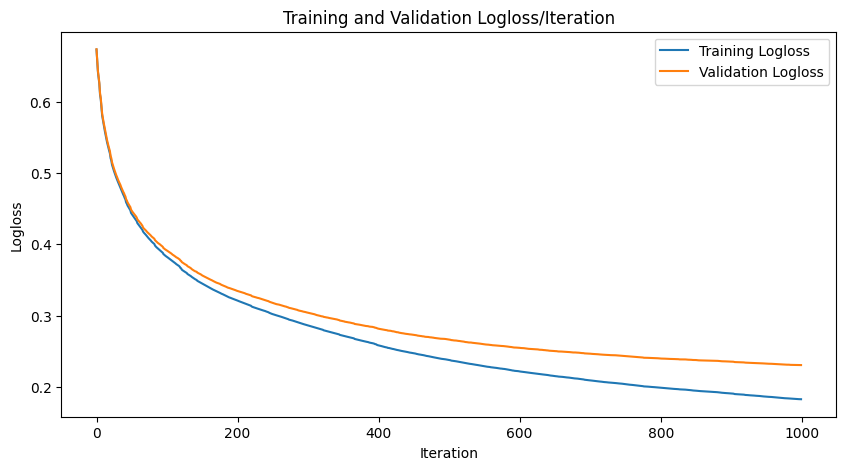

In [22]:
evals_result = clf.get_evals_result()
train_logloss = evals_result['learn']['Logloss']
valid_logloss = evals_result['validation']['Logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_logloss, label='Training Logloss')
plt.plot(valid_logloss, label='Validation Logloss')

plt.title('Training and Validation Logloss/Iteration')

plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.legend()
plt.show()

 Стандартная настройка помогла нам выбить по roc-auc'у .97. Я думаю, нет смысла рассматривать другие методы, чтобы улучшить результат на 0.001. Если сработало это, другие методы если и будут лучше, то не на много

Теперь сделаем все то же самое для тестовых данных

In [23]:
test_df['text'][0]

'j jim whitehead ejw cse ucsc edu writes j you open sourced the new components you developed for this j project so the next person who comes along won t have to j reimplement them right no need all those components already exist either in the java class libraries or from the various java jar collections most of the classes i used came from the jakarta project and apachexml but if it s any consolation my threading of them all together into a newswire server is gpl and available on sourceforge gary lawrence murphy garym teledyn com teledynamics communications inc business advantage through community software url computers are useless they can only give you answers pablo picasso'

In [24]:
for_tokens_list = []
for sent in test_df['text']:
    for_tokens_list.append(re.sub(r'http\S+', '', sent))

for_tokens_list[0]

'j jim whitehead ejw cse ucsc edu writes j you open sourced the new components you developed for this j project so the next person who comes along won t have to j reimplement them right no need all those components already exist either in the java class libraries or from the various java jar collections most of the classes i used came from the jakarta project and apachexml but if it s any consolation my threading of them all together into a newswire server is gpl and available on sourceforge gary lawrence murphy garym teledyn com teledynamics communications inc business advantage through community software url computers are useless they can only give you answers pablo picasso'

In [25]:
text = tokenize_text(for_tokens_list)

In [26]:
text = clean_text(text, stops, stop_marks)

In [27]:
sents = []
for new_sent in text:
    helper = ''
    for word in new_sent:
        helper += ' ' + word
    sents.append(helper.lstrip())
sents[0]

'j jim whitehead ejw cse ucsc edu writes j open sourced new components developed j project next person comes along j reimplement right need components already exist either java class libraries various java jar collections classes used came jakarta project apachexml consolation threading together newswire server gpl available sourceforge gary lawrence murphy garym teledyn com teledynamics communications inc business advantage community software url computers useless give answers pablo picasso'

In [28]:
tf_idf_vectors = tf_idf.transform(sents).toarray()

In [29]:
train_data = pd.DataFrame(tf_idf_vectors)

In [30]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,48288,48289,48290,48291,48292,48293,48294,48295,48296,48297
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
y_preds = clf.predict_proba(train_data)[:, 1].squeeze()

print(y_preds)

[0.10506741 0.49467368 0.01030403 ... 0.13775978 0.06943317 0.00495828]


In [32]:
y_preds = pd.DataFrame(y_preds).rename(columns={0: 'score'}).squeeze()

In [33]:
text_df = pd.DataFrame(test_df['text'])

fin = pd.concat([y_preds, text_df], axis=1)

In [34]:
fin

,score,text
0,0.105067,j jim whitehead ejw cse ucsc edu writes j you ...
1,0.494674,original message from bitbitch magnesium net p...
2,0.010304,java for managers vince durasoft who just taug...
3,0.141118,there is a youtuber name saiman says
4,0.300777,underpriced issue with high return on equity t...
...,...,...
4065,0.137760,husband to wifetum meri zindagi hoorwifeor kya...
4066,0.000992,baylor enron case study cindy yes i shall co a...
4067,0.137760,boring as compared to tp
4068,0.069433,hellogorgeous hows u my fone was on charge lst...


In [36]:
fin.to_csv('ans.csv', index=False)